# XGBDistribution

In [1]:
import time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

from xgboost_distribution import XGBDistribution

## 1. Synthetic data example

In [2]:
def true_function(X):
    return np.sin(3*X)

def true_noise_scale(X):
    return np.abs(np.cos(X))

np.random.seed(123456)
n_samples = 50_000
x_lim = (-2, 0)
X = np.random.uniform(x_lim[0], x_lim[1], n_samples)
y = (
    10*true_function(X) + 10*np.random.normal(
        scale=true_noise_scale(X), size=n_samples
    ) + 50
).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X[..., np.newaxis], y, test_size=0.2)

In [3]:

X = np.random.uniform(x_lim[0], x_lim[1], n_samples)
n = 66*true_noise_scale(X)
p = 0.5*np.abs(np.cos(X/3))+0.0

y = np.random.negative_binomial(n=n, p=p, size=n_samples)

X_train, X_test, y_train, y_test = train_test_split(X[..., np.newaxis], y, test_size=0.2)

In [4]:
X = np.random.uniform(x_lim[0], x_lim[1], n_samples)
scale = 18*true_noise_scale(X)

y = np.random.exponential(scale=scale, size=n_samples)

X_train, X_test, y_train, y_test = train_test_split(X[..., np.newaxis], y, test_size=0.2)

In [5]:
start = time.time()
model = XGBDistribution(
    distribution="normal",
    natural_gradient=True,
    max_depth=None,
    n_estimators=500,
    #enable_categorical=True,
    #tree_method="gpu_hist"
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False
)
print(model.best_iteration)
print(time.time()-start)

24
3.6132709980010986


In [6]:
xx = np.linspace(x_lim[0], x_lim[1], 201)
yy = np.linspace(0, 100, 100)

preds = model.predict(xx[..., np.newaxis])

ym, xm = np.meshgrid(xx, yy)

if model.distribution == "negative-binomial":
    z = np.array([
        getattr(stats, "nbinom").pmf(
            yy, n=preds.n[ii], p=preds.p[ii]
        ) for ii, x in enumerate(xx)
    ])
elif model.distribution == "poisson":
    z = np.array([
        getattr(stats, "poisson").pmf(yy, mu=preds.mu[ii]) for ii, x in enumerate(xx)
    ])
elif model.distribution == "normal":
    z = np.array([
        getattr(stats, "norm").pdf(
            yy, loc=preds.loc[ii], scale=preds.scale[ii]
        ) for ii, x in enumerate(xx)
    ])
elif model.distribution == "log-normal":
    z = np.array([
        getattr(stats, "lognorm").pdf(
            yy, scale=preds.scale[ii], s=preds.s[ii]
        ) for ii, x in enumerate(xx)
    ])
elif model.distribution == "exponential":
    z = np.array([
        getattr(stats, "expon").pdf(yy, scale=preds.scale[ii]) for ii, x in enumerate(xx)
    ])
elif model.distribution == "laplace":
    z = np.array([
        getattr(stats, "laplace").pdf(yy, loc=preds.loc[ii], scale=preds.scale[ii]) for ii, x in enumerate(xx)
    ])

for val in z:
    val /= val.max()

z = z.transpose()

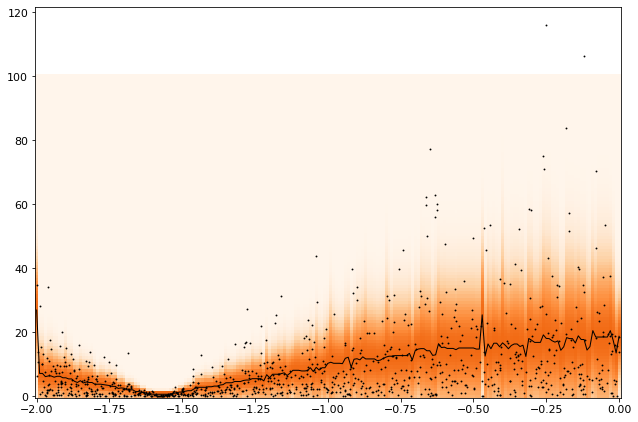

In [7]:
plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize=(9, 6))

c = ax.pcolormesh(
    ym, xm, z, 
    cmap="Oranges", 
    vmin=0, 
    vmax=1.608, 
    alpha=1.0, 
    shading="auto"
)

ax.scatter(X[:1000], y[:1000], s=0.75, c='k', label='data')
# ax.set_ylim((-0, 50))

ax.plot(
    xx, preds.loc, '-', label='XGBDistribution mean', 
    color='k', linewidth=1.0
)
# ax.plot(
#     xx, loc + scale, '--', label='XGBDistribution $1 \sigma$', 
#     color='k', linewidth=0.75
# )
# ax.plot(
#     xx, loc - scale, '--',
#     color='k', linewidth=0.75
# )
# plt.minorticks_on()

# ax.set_title("XGBDistribution: lognormal distribution")

# ax.set_ylabel("y")
# ax.set_xlabel("x")
# ax.legend()

fig.tight_layout()
#fig.savefig("../xgb_dist.png")

In [8]:
preds.scale

array([11.530089  ,  6.3354745 ,  6.3354745 ,  5.562154  ,  6.106806  ,
        6.106806  ,  5.6715274 ,  5.4525723 ,  4.8717003 ,  4.9780946 ,
        6.047239  ,  4.9628344 ,  4.8144655 ,  4.1554394 ,  4.1554394 ,
        4.3924017 ,  4.374721  ,  4.032505  ,  3.9494455 ,  4.03949   ,
        3.5218742 ,  2.8113215 ,  3.1669695 ,  3.1065516 ,  2.839141  ,
        3.0436466 ,  2.7592795 ,  2.83215   ,  2.1922476 ,  2.206504  ,
        2.0210104 ,  1.6728    ,  1.7270633 ,  1.6243352 ,  1.4735872 ,
        1.2298348 ,  0.9923614 ,  0.99925643,  0.7459899 ,  0.7235592 ,
        0.6620263 ,  0.62949926,  0.62949926,  0.62949926,  0.62949926,
        0.60122603,  0.66798604,  0.75826067,  0.86684746,  1.1152924 ,
        1.1599799 ,  1.4034793 ,  1.5249823 ,  1.5908792 ,  1.8744185 ,
        2.203204  ,  2.2979038 ,  2.4487705 ,  2.7344844 ,  2.5362775 ,
        2.600558  ,  2.965643  ,  2.965643  ,  3.3985689 ,  3.2073333 ,
        4.089109  ,  3.7275128 ,  3.7275128 ,  3.5558147 ,  4.11

## 2. NGBoost comparison

In [9]:
from ngboost import NGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

In [10]:
data = load_boston()

X, y = data.data, data.target

# X, y = gen_data(1_000_000, random_state=42)


RANDOM_STATE = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1, 
    random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1, 
    random_state=RANDOM_STATE
)

In [13]:
def eval_ngboost():
    start = time.perf_counter()
    
    model = NGBRegressor(
        verbose=True
    )
    model.fit(
        X_train, y_train,
        X_val=X_val,
        Y_val=y_val,
        early_stopping_rounds=10,
    )
    n = model.pred_dist(X_test)
    
    return n.loc, n.scale, time.perf_counter()-start

def eval_xgb_dist():
    start = time.perf_counter()

    model = XGBDistribution(
        max_depth=3,
        n_estimators=500,
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )    
    preds =  model.predict(X_test)
    return preds.loc, preds.scale, time.perf_counter()-start


def eval_xgb_regr():
    model = XGBRegressor(
        max_depth=3,
        n_estimators=500,
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )
    print(model.best_iteration, model.best_score)
    return model.predict(X_test), 0.001*model.predict(X_test)


In [14]:
ngb_res = eval_ngboost()

[iter 0] loss=3.6205 val_loss=3.7053 scale=1.0000 norm=6.5782
[iter 100] loss=2.7435 val_loss=2.8551 scale=2.0000 norm=5.1757
[iter 200] loss=2.1868 val_loss=2.4973 scale=2.0000 norm=3.5557
== Early stopping achieved.
== Best iteration / VAL204 (val_loss=2.4947)


In [15]:
xgbd_res = eval_xgb_dist()

In [89]:
eval_results = {
    "XGBDistribution": xgbd_res,
    "NGBRegressor": ngb_res,
    #"XGBRegressor": eval_xgb_regr()
}

In [90]:
def root_mean_squared_error(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))


def normal_nll(loc, scale, y_test):
    return -stats.norm.logpdf(y_test.flatten(), loc=loc, scale=scale).mean()

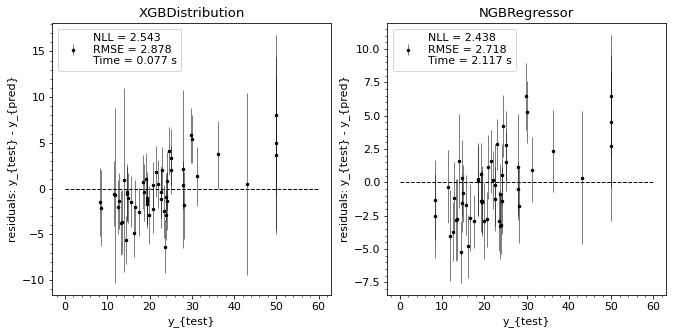

In [91]:
fig, axes = plt.subplots(ncols=len(eval_results.keys()), figsize=(11, 5))

plt.rcParams.update({'font.size': 11})

for ii, (name, results) in enumerate(eval_results.items()):
    axes[ii].set_title(
        f"{name}"
    )
    
    axes[ii].errorbar(
        y_test, y_test-results[0], yerr=results[1],
        marker='o', linestyle='None', c='k',
        markersize=2.5,
        linewidth=0.5,
        label=(
            f"NLL = {round(normal_nll(results[0], results[1], y_test), 3)}\n"
            f"RMSE = {round(root_mean_squared_error(y_test, results[0]), 3)}\n"
            f"Time = {round(results[2], 3)} s"
        ),
    )
    axes[ii].plot(
        [0, 60], [0, 0], '--', c='k',
        linewidth=1.0
    )
    
    axes[ii].legend(loc='upper left')
#     axes[ii].set_xlim((0, 55))
#     axes[ii].set_ylim((-10, 15))

    axes[ii].set_xlabel("y_{test}")
    axes[ii].set_ylabel("residuals: y_{test} - y_{pred}")
    axes[ii].minorticks_on()

fig.savefig("../imgs/performance_comparison.png")
plt.show()

## 3. Monotonic constraints

In [39]:
def gen_data(n_samples=1_000, random_state=1):
    np.random.seed(random_state)
    x_1 = np.linspace(0, 1, n_samples)
    y = 5*x_1 + np.sin(10*np.pi*x_1) + np.random.normal(size=n_samples)
    return x_1[..., np.newaxis], y

In [40]:
X_train, y_train = gen_data(10_000, random_state=42)
X_test, y_test = gen_data(1_000, random_state=0)


models = [
    XGBDistribution(n_estimators=500, max_depth=3),
    XGBDistribution(n_estimators=500, max_depth=3, monotone_constraints="(1)"),
]

preds = list()

for model in models:
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    preds.append(model.predict(X_test))

Text(0.5, 1.0, 'XGBDistribution: monotone_constraint')

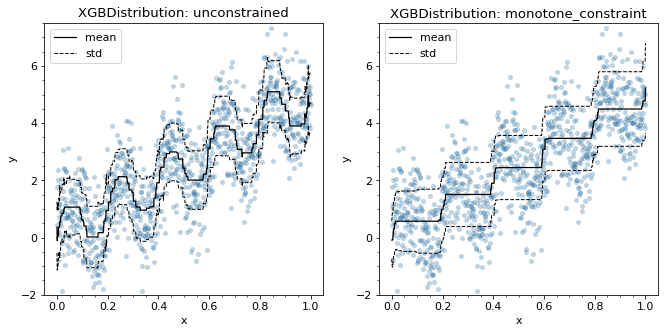

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 5))

for ax, pred in zip(axes, preds):
    ax.scatter(x=X_test[:,0], y=y_test, s=20.0, alpha=0.3, edgecolors='k', linewidths=0.2)
    ax.plot(
        X_test[:,0], pred.loc, "-", c='k', lw=1.25, label="mean"
    )
    ax.plot(
        X_test[:,0], pred.loc+pred.scale, "--", c='k', lw=1.0, label="std") 
    ax.plot(X_test[:,0], pred.loc-pred.scale, "--", c='k', lw=1.0) 
    ax.legend()
    ax.set_ylim((-2, 7.5))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.minorticks_on()
    
axes[0].set_title("XGBDistribution: unconstrained")
axes[1].set_title("XGBDistribution: monotone_constraint")

# fig.savefig("../imgs/monotone_constraint.png")

# bicycle

In [18]:
df = pd.read_csv(
    '../data/nyc_bb_bicyclist_counts.csv', 
    header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0]
)

In [19]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [20]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

In [21]:
y_train = df_train.pop('BB_COUNT')
X_train = df_train
y_test = df_test.pop("BB_COUNT")
X_test = df_test


In [22]:
model = XGBDistribution(
    distribution="negative-binomial",
    natural_gradient=True,
    max_depth=None,
    n_estimators=500
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)

[0]	validation_0-NegativeBinomialError:55.29851
[1]	validation_0-NegativeBinomialError:45.86651
[2]	validation_0-NegativeBinomialError:47.92167
[3]	validation_0-NegativeBinomialError:45.45921
[4]	validation_0-NegativeBinomialError:46.43630
[5]	validation_0-NegativeBinomialError:45.43794
[6]	validation_0-NegativeBinomialError:44.98524
[7]	validation_0-NegativeBinomialError:45.41361
[8]	validation_0-NegativeBinomialError:46.35137
[9]	validation_0-NegativeBinomialError:46.54227
[10]	validation_0-NegativeBinomialError:46.13059
[11]	validation_0-NegativeBinomialError:46.86285
[12]	validation_0-NegativeBinomialError:47.59886
[13]	validation_0-NegativeBinomialError:47.84412
[14]	validation_0-NegativeBinomialError:48.07722
[15]	validation_0-NegativeBinomialError:47.77152
[16]	validation_0-NegativeBinomialError:47.84230


XGBDistribution(base_score=0.0, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1,
                distribution='negative-binomial', gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=500, n_jobs=4, num_parallel_tree=1,
                objective='multi:softmax', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=None, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
xx = np.linspace(0, len(X_test), len(X_test))
yy = np.linspace(y_test.min(), y_test.max(), y_test.max()-y_test.min()+1)

preds = model.predict(X_test)

pred_mean = preds.n / preds.p - preds.n
pred_var = pred_mean / preds.p
pred_std = np.sqrt(pred_var)

ym, xm = np.meshgrid(xx, yy)

z = np.array([
    stats.nbinom.pmf(yy, n=preds.n[ii], p=preds.p[ii]) for ii, x in enumerate(xx)
])

# for val in z:
#     val /= val.max()

z = z.transpose()

<ErrorbarContainer object of 3 artists>

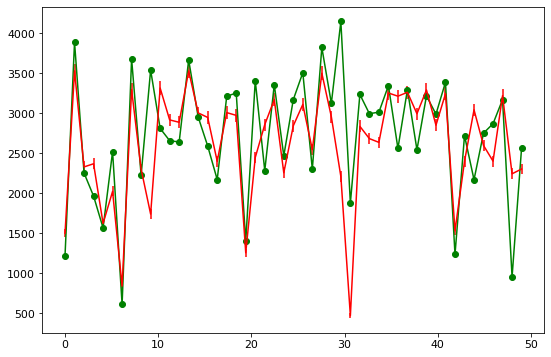

In [24]:
fig, ax = plt.subplots(figsize=(9, 6))

# c = ax.pcolormesh(
#     ym, xm, z, 
#     cmap="Oranges", 
# #     vmin=0, 
# #     vmax=1.608, 
#     alpha=1.0, 
#     shading="auto"
# )


ax.plot(xx, y_test, 'go-') #, s=0.75, c='k', label='data')

ax.errorbar(xx, pred_mean, yerr=pred_std, c="r")